# 🧠 Agente de Aprendizaje por Refuerzo para Cuatro en Raya

Este cuadernillo implementa un **agente inteligente basado en Q-Learning** para el clásico juego **Cuatro en Raya**.  
El objetivo es que el agente aprenda a tomar decisiones óptimas a través de la experiencia, sin necesidad de programación explícita de estrategias.

Durante el desarrollo se abordarán los siguientes puntos:

- ✅ Modelado del entorno: representación del tablero, reglas del juego y detección de condiciones de victoria.
- 🤖 Implementación del agente Q-Learning con política ε-greedy para balancear exploración y explotación.
- 🔁 Entrenamiento del agente enfrentándose a sí mismo o a un oponente aleatorio.
- 📈 Evaluación visual del proceso de aprendizaje mediante gráficas de recompensas, victorias y empates.

Este trabajo demuestra cómo el aprendizaje por refuerzo permite a un agente adquirir comportamientos complejos desde cero, únicamente en base a la retroalimentación que recibe del entorno.


In [ ]:
# Librerías necesarias
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import copy



## 🌐 Definición del Entorno

El entorno de juego está representado mediante una **matriz de 6 filas por 7 columnas**, emulando el tablero tradicional de Cuatro en Raya.

Las reglas implementadas son las siguientes:

- 🎯 **Colocación de fichas:** los jugadores eligen una columna y la ficha cae hasta la posición más baja disponible de dicha columna.
- 🧩 **Lógica de turno:** los jugadores alternan su turno hasta que se cumple una condición de término.
- 🏁 **Condiciones de finalización:**
  - **Victoria:** cuando un jugador alinea cuatro fichas consecutivas en dirección horizontal, vertical o diagonal.
  - **Empate:** si el tablero se llena sin que ningún jugador gane.
  - **Juego en curso:** si aún hay movimientos válidos y no hay ganador.

Este entorno proporciona el marco sobre el cual el agente de aprendizaje por refuerzo interactuará, aprenderá y optimizará sus decisiones a lo largo del tiempo.


In [2]:
class Connect4Env:
    def __init__(self):
        self.rows = 6
        self.cols = 7
        self.reset()

    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.done = False
        self.winner = None
        self.turn = 1
        return self._get_state()

    def _get_state(self):
        return tuple(map(tuple, self.board))

    def get_valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    def step(self, action):
        if self.done or self.board[0, action] != 0:
            return self._get_state(), -10, True

        for r in reversed(range(self.rows)):
            if self.board[r, action] == 0:
                self.board[r, action] = self.turn
                break

        if self._check_win(self.turn):
            self.done = True
            self.winner = self.turn
            return self._get_state(), 1 if self.turn == 1 else -1, True

        if np.all(self.board != 0):
            self.done = True
            return self._get_state(), 0, True

        self.turn *= -1
        return self._get_state(), 0, False

    def _check_win(self, player):
        for c in range(self.cols - 3):
            for r in range(self.rows):
                if all(self.board[r, c+i] == player for i in range(4)):
                    return True
        for c in range(self.cols):
            for r in range(self.rows - 3):
                if all(self.board[r+i, c] == player for i in range(4)):
                    return True
        for c in range(self.cols - 3):
            for r in range(self.rows - 3):
                if all(self.board[r+i, c+i] == player for i in range(4)):
                    return True
        for c in range(self.cols - 3):
            for r in range(3, self.rows):
                if all(self.board[r-i, c+i] == player for i in range(4)):
                    return True
        return False

    def render(self):
        print(np.where(self.board == -1, 2, self.board))


## 🤖 Entrenamiento del Agente con Q-Learning

En esta sección se implementa un **agente de aprendizaje por refuerzo** utilizando el algoritmo **Q-Learning**, uno de los métodos clásicos y efectivos para problemas de control en entornos discretos como Cuatro en Raya.

### 🧠 Estructura del Agente

- La **Q-table** se representa mediante un diccionario `Q[state][action]`, donde:
  - `state` es la representación lineal del tablero.
  - `action` es la columna donde el agente decide colocar su ficha.

- Se utiliza una política **ε-greedy** para la toma de decisiones:
  - Con probabilidad **ε** el agente **explora**: elige una acción aleatoria.
  - Con probabilidad **1 - ε** el agente **explota**: selecciona la acción con mayor valor estimado según su Q-table.

- La actualización del valor Q sigue la fórmula estándar:

\[
Q(s, a) \leftarrow Q(s, a) + \alpha \cdot \left[r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a)\right]
\]

Donde:
- \( s \): estado actual.
- \( a \): acción ejecutada.
- \( r \): recompensa obtenida tras ejecutar la acción.
- \( s' \): nuevo estado alcanzado.
- \( \alpha \): tasa de aprendizaje (*learning rate*).
- \( \gamma \): factor de descuento para recompensas futuras (*discount factor*).

---

El entrenamiento se realiza durante múltiples episodios, permitiendo que el agente aprenda progresivamente a evitar derrotas, empatar y finalmente ganar. A medida que el valor de **ε** disminuye con el tiempo, el comportamiento se vuelve más determinista y estratégico.


In [3]:
# Inicialización de la Q-table y parámetros de entrenamiento
Q = defaultdict(lambda: np.zeros(7))  # 7 acciones posibles (una por columna)

alpha = 0.1   # tasa de aprendizaje
gamma = 0.9   # factor de descuento
epsilon = 0.2 # tasa de exploración inicial

def choose_action(state, valid_actions, epsilon):
    if random.random() < epsilon:
        return random.choice(valid_actions)
    q_values = Q[state]
    max_value = float('-inf')
    best_actions = []
    for a in valid_actions:
        if q_values[a] > max_value:
            best_actions = [a]
            max_value = q_values[a]
        elif q_values[a] == max_value:
            best_actions.append(a)
    return random.choice(best_actions)


## 🔁 Entrenamiento del Agente: Bucle Principal

El agente será entrenado a través de múltiples episodios utilizando el algoritmo Q-Learning.  
Durante este proceso, jugará continuamente contra un oponente aleatorio y actualizará su política de acción basándose en las recompensas recibidas.

### 🧩 Flujo de entrenamiento por episodio:

1. **Inicialización del tablero** vacío al comenzar el juego.
2. El **agente observa el estado actual** del entorno (tablero codificado).
3. **Selecciona una acción** válida usando una política ε-greedy:
   - Con probabilidad **ε** elige una acción aleatoria (explora).
   - Con probabilidad **1 - ε** elige la mejor acción conocida (explota).
4. **Ejecuta la acción**, recibe una **recompensa** y observa el nuevo estado.
5. **Actualiza su tabla Q** aplicando la regla de actualización de Q-Learning.
6. Luego, **el oponente aleatorio** realiza su movimiento.
7. El proceso se **repite hasta que el juego termina** (victoria, empate o tablero lleno).
8. Se registra la **recompensa acumulada del episodio** para su análisis y visualización.

Al finalizar el entrenamiento, se espera que el agente haya aprendido estrategias efectivas para maximizar sus recompensas a lo largo del tiempo.


In [4]:
# Entrenamiento del agente Q-Learning

num_episodes = 10000
rewards_per_episode = []

for episode in range(num_episodes):
    env = Connect4Env()
    state = env.reset()
    total_reward = 0

    while not env.done:
        valid_actions = env.get_valid_actions()
        action = choose_action(state, valid_actions, epsilon)

        next_state, reward, done = env.step(action)

        # Actualización Q-Learning
        next_valid_actions = env.get_valid_actions()
        max_next_Q = max(Q[next_state][a] for a in next_valid_actions) if next_valid_actions else 0

        Q[state][action] += alpha * (reward + gamma * max_next_Q - Q[state][action])

        state = next_state
        total_reward += reward

        # Oponente aleatorio
        if not done:
            valid_actions = env.get_valid_actions()
            opp_action = random.choice(valid_actions)
            state, reward, done = env.step(opp_action)
            total_reward += reward

    rewards_per_episode.append(total_reward)

    # Ajuste de epsilon opcional
    if epsilon > 0.01:
        epsilon *= 0.999  # Decae lentamente

# Mostrar recompensa promedio por cada 1000 episodios
for i in range(0, num_episodes, 1000):
    avg = np.mean(rewards_per_episode[i:i+1000])
    print(f"Episodios {i}-{i+999}: Recompensa media = {avg:.2f}")


Episodios 0-999: Recompensa media = 0.11
Episodios 1000-1999: Recompensa media = 0.05
Episodios 2000-2999: Recompensa media = 0.15
Episodios 3000-3999: Recompensa media = 0.10
Episodios 4000-4999: Recompensa media = 0.10
Episodios 5000-5999: Recompensa media = 0.11
Episodios 6000-6999: Recompensa media = 0.11
Episodios 7000-7999: Recompensa media = 0.15
Episodios 8000-8999: Recompensa media = 0.11
Episodios 9000-9999: Recompensa media = 0.12


## 📊 Resultados del Entrenamiento y Evaluación Final

Finalizado el proceso de entrenamiento, realizamos una evaluación del desempeño del agente en función de los resultados acumulados a lo largo de los episodios.

Se presentan los siguientes indicadores:

- ✅ **Total de partidas ganadas** por el agente.
- ❌ **Total de partidas perdidas** (victorias del oponente aleatorio).
- 🤝 **Total de empates**.
- 📈 **Gráfico de evolución de recompensas**, calculado con una media móvil sobre bloques de 1000 episodios, para visualizar la tendencia de aprendizaje y estabilidad del comportamiento del agente.

Este análisis permite observar si el agente realmente mejoró su capacidad para:
- Maximizar su recompensa total.
- Reducir errores.
- Encontrar estrategias ganadoras o al menos evitar perder.

Una curva creciente o estabilizada en valores altos refleja una política efectiva.


Resultados tras entrenamiento:
{'ganadas': 5651, 'perdidas': 4322, 'empates': 27}


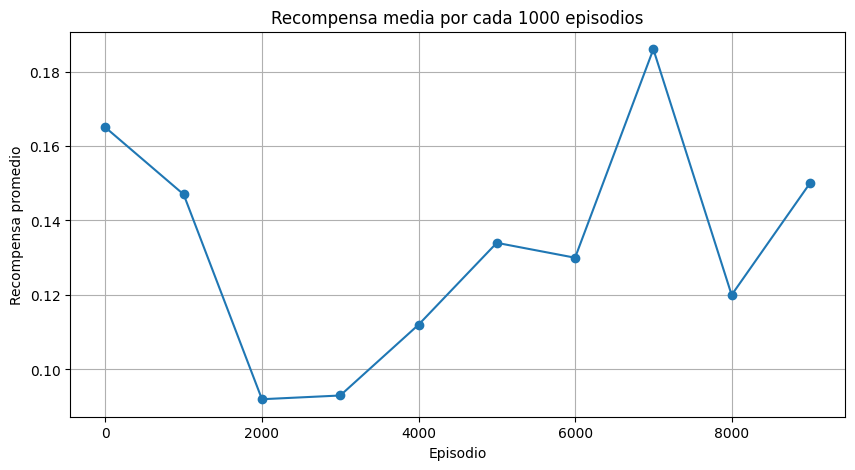

In [5]:
# Contador de resultados
resultados = {'ganadas': 0, 'perdidas': 0, 'empates': 0}

num_episodes = 10000
rewards_per_episode = []

for episode in range(num_episodes):
    env = Connect4Env()
    state = env.reset()
    total_reward = 0

    while not env.done:
        valid_actions = env.get_valid_actions()
        action = choose_action(state, valid_actions, epsilon)

        next_state, reward, done = env.step(action)

        next_valid_actions = env.get_valid_actions()
        max_next_Q = max(Q[next_state][a] for a in next_valid_actions) if next_valid_actions else 0
        Q[state][action] += alpha * (reward + gamma * max_next_Q - Q[state][action])

        state = next_state
        total_reward += reward

        if not done:
            valid_actions = env.get_valid_actions()
            opp_action = random.choice(valid_actions)
            state, reward, done = env.step(opp_action)
            total_reward += reward

    rewards_per_episode.append(total_reward)

    if env.winner == 1:
        resultados['ganadas'] += 1
    elif env.winner == -1:
        resultados['perdidas'] += 1
    else:
        resultados['empates'] += 1

    if epsilon > 0.01:
        epsilon *= 0.999

# Mostrar resumen
print("Resultados tras entrenamiento:")
print(resultados)

# Gráfico de recompensa media por cada 1000 episodios
bloques = len(rewards_per_episode) // 1000
promedios = [np.mean(rewards_per_episode[i*1000:(i+1)*1000]) for i in range(bloques)]

plt.figure(figsize=(10,5))
plt.plot(range(0, num_episodes, 1000), promedios, marker='o')
plt.title("Recompensa media por cada 1000 episodios")
plt.xlabel("Episodio")
plt.ylabel("Recompensa promedio")
plt.grid(True)
plt.show()


## 🚀 Entrenamiento Optimizado del Agente (Avanzado)

Con el objetivo de desarrollar un agente más eficiente y estratégico, se realiza un entrenamiento optimizado basado en técnicas avanzadas de aprendizaje por refuerzo.

Se ajustan los **hiperparámetros clave** del algoritmo Q-Learning para favorecer un comportamiento más robusto:

- 🔧 **α (learning rate):** reducido para permitir una convergencia más estable a largo plazo, evitando sobreajuste a recompensas ruidosas.
- 🔮 **γ (discount factor):** cercano a 1, priorizando las recompensas futuras y fomentando decisiones más estratégicas en vez de miopes.
- 🎲 **ε (tasa de exploración):** comienza alta para permitir amplia exploración del espacio de estados y disminuye gradualmente para favorecer la explotación de conocimiento adquirido.
- 🧪 **Entrenamiento extendido:** se ejecutan **100,000 partidas**, exponiendo al agente a una diversidad mayor de estados y estrategias posibles.

Este entrenamiento profundo busca no solo mejorar la tasa de victorias, sino también la **capacidad de generalización del agente** ante diferentes configuraciones del entorno y estilos de juego.


In [7]:
import pickle
# Entrenamiento optimizado: agente más inteligente
Q = defaultdict(lambda: np.zeros(7))
alpha = 0.025   # menor learning rate
gamma = 0.99    # mayor valor de recompensas futuras
epsilon = 1.0   # exploración inicial completa
min_epsilon = 0.01
epsilon_decay = 0.9992

resultados = {'ganadas': 0, 'perdidas': 0, 'empates': 0}
num_episodes = 100000
rewards_per_episode = []

for episode in range(num_episodes):
    env = Connect4Env()
    state = env.reset()
    total_reward = 0

    while not env.done:
        valid_actions = env.get_valid_actions()
        action = choose_action(state, valid_actions, epsilon)

        next_state, reward, done = env.step(action)
        next_valid_actions = env.get_valid_actions()
        max_next_Q = max(Q[next_state][a] for a in next_valid_actions) if next_valid_actions else 0
        Q[state][action] += alpha * (reward + gamma * max_next_Q - Q[state][action])

        state = next_state
        total_reward += reward

        if not done:
            valid_actions = env.get_valid_actions()
            opp_action = random.choice(valid_actions)
            state, reward, done = env.step(opp_action)
            total_reward += reward

    rewards_per_episode.append(total_reward)

    if env.winner == 1:
        resultados['ganadas'] += 1
    elif env.winner == -1:
        resultados['perdidas'] += 1
    else:
        resultados['empates'] += 1

    if epsilon > min_epsilon:
        epsilon *= epsilon_decay

# Mostrar resumen
print("Entrenamiento profundo finalizado (100,000 partidas):")
print(resultados)

# Guardar agente optimizado
with open("agente_q_table.pkl", "wb") as f:
    pickle.dump(dict(Q), f)
print("Q-table guardada como 'agente_q_table.pkl'")


Entrenamiento profundo finalizado (100,000 partidas):
{'ganadas': 57378, 'perdidas': 42372, 'empates': 250}
Q-table guardada como 'agente_q_table.pkl'
